In [ ]:
# Import packages
import numpy as np
import pandas as pd
import chardet
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import string
import time

# Display plots inline
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import concatenate
from keras.optimizers import Adam
from keras.preprocessing.text import one_hot
from keras.callbacks import ModelCheckpoint

from scipy import sparse, stats

In [ ]:
# Download nltk - only need to run once
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Get encoding of data file
with open("/content/author_data.csv", 'rb') as file:
    print(chardet.detect(file.read()))

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [ ]:
# Load data (uncomment relevant line)
# Local version
#data = pd.read_csv("author_data.csv", encoding="Windows-1252")

# Floydhub version
data = pd.read_csv("/content/author_data.csv", encoding="utf-8")
print(data.head())

                                                text               author
0                                            JULIET.  William Shakespeare
1  Dr. Adams, {294b} one of the canons, invited m...       Jonathan Swift
2  I had in this closet a field bed, and a hammoc...       Jonathan Swift
3                                           CASSIUS.  William Shakespeare
4                                 "Get out with you.      Charles Dickens


In [ ]:
# Create feature (text) and label (author) lists
text = list(data['text'].values)
author = list(data['author'].values)

print("The author dataset contains {} datapoints.".format(len(text)))

The author dataset contains 90000 datapoints.


In [ ]:
# Check distribution of authors in the data
Counter(author)

Counter({'William Shakespeare': 10000,
         'Jonathan Swift': 10000,
         'Charles Dickens': 10000,
         'Oscar Wilde': 10000,
         'Robert Louis Stevenson': 10000,
         'Jane Austen': 10000,
         'Mark_Twain': 10000,
         'Rudyard Kipling': 10000,
         'Bram Stoker': 10000})

In [ ]:
# Create word count and character count lists
word_count = []
char_count = []

for i in range(len(text)):
    word_count.append(len(text[i].split()))
    char_count.append(len(text[i]))

# Convert lists to numpy arrays
word_count = np.array(word_count)
char_count = np.array(char_count)

# Calculate average word lengths
ave_length = np.array(char_count)/np.array(word_count)

In [ ]:
def get_stats(var):
    """Print summary statistics for a variable of interest.

    Args:
    var: array. Numpy array containing values for the variable of interest.

    Returns:
    None
    """
    print("Min:", np.min(var))
    print("Max:", np.max(var))
    print("Mean:", np.mean(var))
    print("Median", np.median(var))
    print("1st percentile", np.percentile(var, 1))
    print("95th percentile", np.percentile(var, 95))
    print("99th percentile", np.percentile(var, 99))
    print("99.5th Percentile", np.percentile(var, 99.5))
    print("99.9th Percentile", np.percentile(var, 99.9))

In [ ]:
print("Word count statistics")
get_stats(word_count)

Word count statistics
Min: 1
Max: 351
Mean: 18.314
Median 13.0
1st percentile 1.0
95th percentile 51.0
99th percentile 79.0
99.5th Percentile 94.0
99.9th Percentile 131.00100000000384


<ipython-input-14-6002e2826dcd>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word_count, kde = False, bins = 70, color = 'blue').set_title("Word Count Distribution")


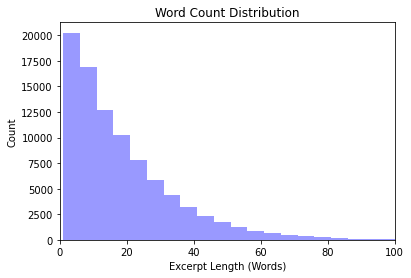

In [ ]:
# Plot word count distribution
sns.distplot(word_count, kde = False, bins = 70, color = 'blue').set_title("Word Count Distribution")
plt.xlabel('Excerpt Length (Words)')
plt.ylabel('Count')
plt.xlim(0, 100)
plt.savefig("word_count.eps")

In [ ]:
print("\nCharacter count statistics")
get_stats(char_count)


Character count statistics
Min: 5
Max: 1806
Mean: 98.89027777777778
Median 71.0
1st percentile 6.0
95th percentile 281.0
99th percentile 437.0
99.5th Percentile 514.0
99.9th Percentile 740.0030000000115


<ipython-input-16-8e4bef13dec1>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(char_count, kde = False, bins = 100, color = 'blue').set_title("Character Count Distribution")


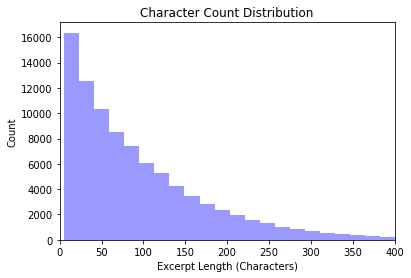

In [ ]:
# Plot character count distribution
sns.distplot(char_count, kde = False, bins = 100, color = 'blue').set_title("Character Count Distribution")
plt.xlabel('Excerpt Length (Characters)')
plt.ylabel('Count')
plt.xlim(0, 400)
plt.savefig("char_count.eps")


In [ ]:
print("\nAverage length statistics")
get_stats(ave_length)


Average length statistics
Min: 2.3333333333333335
Max: 37.0
Mean: 5.542040240491161
Median 5.363636363636363
1st percentile 3.8
95th percentile 7.5
99th percentile 10.0
99.5th Percentile 10.0
99.9th Percentile 14.0


<ipython-input-18-e0a359e7a16a>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ave_length, kde = False, bins = 70, color = 'blue').set_title("Average Word Length Distribution")


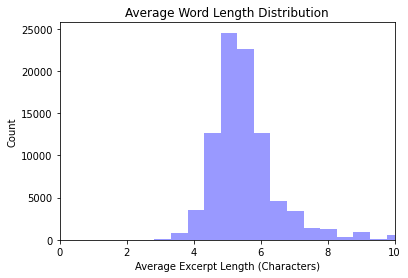

In [ ]:
# Plot average excerpt length distribution
sns.distplot(ave_length, kde = False, bins = 70, color = 'blue').set_title("Average Word Length Distribution")
plt.xlabel('Average Excerpt Length (Characters)')
plt.ylabel('Count')
plt.xlim(0, 10)
plt.savefig("ave_length.eps")

In [ ]:
# Get word count outliers
word_outliers = np.where(word_count > 150)

for i in word_outliers[0]:
    print("Excerpt {} - Length: {}".format(i, word_count[i]))
    print(text[i], "\n")

Excerpt 1235 - Length: 173
“‘We were so robbed by that man who stands there, as all we common dogs are by those superior Beings taxed by him without mercy, obliged to work for him without pay, obliged to grind our corn at his mill, obliged to feed scores of his tame birds on our wretched crops, and forbidden for our lives to keep a single tame bird of our own, pillaged and plundered to that degree that when we chanced to have a bit of meat, we ate it in fear, with the door barred and the shutters closed, that his people should not see it and take it from us I say, we were so robbed, and hunted, and were made so poor, that our father told us it was a dreadful thing to bring a child into the world, and that what we should most pray for, was, that our women might be barren and our miserable race die out!’  “I had never before seen the sense of being oppressed, bursting forth like a fire. 

Excerpt 2991 - Length: 218
He told them he was a pirate been a pirate for thirty years out in the In

In [ ]:
word_outliers = np.where(word_count < 2)

for i in word_outliers[0]:
  print("Excerpt {} - Length: {}".format(i, word_count[i]))
  print(text[i], "\n")

Streaming output truncated to the last 5000 lines.
CECILY. 

Excerpt 60172 - Length: 1
CHARLES. 

Excerpt 60187 - Length: 1
ANTONY. 

Excerpt 60215 - Length: 1
CAESAR. 

Excerpt 60219 - Length: 1
"Charmed! 

Excerpt 60222 - Length: 1
HESTER. 

Excerpt 60227 - Length: 1
Farewell. 

Excerpt 60228 - Length: 1
JULIET. 

Excerpt 60248 - Length: 1
NURSE. 

Excerpt 60261 - Length: 1
ALGERNON. 

Excerpt 60266 - Length: 1
Amen. 

Excerpt 60267 - Length: 1
ENOBARBUS. 

Excerpt 60275 - Length: 1
[Exeunt.] 

Excerpt 60286 - Length: 1
TOUCHSTONE. 

Excerpt 60298 - Length: 1
Darling! 

Excerpt 60305 - Length: 1
[Exeunt.] 

Excerpt 60322 - Length: 1
ARBUTHNOT.] 

Excerpt 60369 - Length: 1
SERVANT. 

Excerpt 60394 - Length: 1
LANE. 

Excerpt 60423 - Length: 1
JULIET. 

Excerpt 60548 - Length: 1
POMPEY. 

Excerpt 60565 - Length: 1
“Heaps. 

Excerpt 60573 - Length: 1
KELVIL. 

Excerpt 60619 - Length: 1
CASSIUS. 

Excerpt 60671 - Length: 1
HESTER. 

Excerpt 60694 - Length: 1
“What”? 

Excerpt 60713 - Len

In [ ]:
# Get average length outliers
length_outliers = np.where(ave_length > 10)

for i in length_outliers[0]:
    print("Excerpt {} - Average Length: {}".format(i, ave_length[i]))
    print(text[i], "\n")

Excerpt 124 - Average Length: 11.0
TOUCHSTONE. 

Excerpt 166 - Average Length: 11.0
ARBUTHNOT.] 

Excerpt 421 - Average Length: 11.0
TOUCHSTONE. 

Excerpt 513 - Average Length: 12.0
Proportions, fore-shortening.—Oh no! 

Excerpt 812 - Average Length: 11.0
[Knocking.] 

Excerpt 1072 - Average Length: 10.5
Good-night, Gertrude! 

Excerpt 1624 - Average Length: 10.083333333333334
THE STAR-CHILD                                       TO                            MISS MARGOT TENNANT                               [MRS. ASQUITH]  ONCE upon a time two poor Woodcutters were making their way home through a great pine-forest. 

Excerpt 1643 - Average Length: 11.0
SOOTHSAYER. 

Excerpt 1747 - Average Length: 12.0
[Languidly.] 

Excerpt 1951 - Average Length: 21.0
THE LIZARD,                                                             December 31. 

Excerpt 1977 - Average Length: 16.0
“Extermination”. 

Excerpt 2050 - Average Length: 25.0
“Compound—experiment—N.G. 

Excerpt 2232 - Average Length: 1

In [ ]:
length_outliers = np.where(ave_length < 3.5)

for i in length_outliers[0]:
    print("Excerpt {} - Average Length: {}".format(i, ave_length[i]))
    print(text[i], "\n")

Excerpt 362 - Average Length: 3.3333333333333335
so I hear. 

Excerpt 658 - Average Length: 3.4
“I am sure of it. 

Excerpt 1600 - Average Length: 3.3333333333333335
He is mad. 

Excerpt 2122 - Average Length: 3.3333333333333335
I know it! 

Excerpt 2195 - Average Length: 3.2
Not I, vow to  ! 

Excerpt 2698 - Average Length: 3.0
but I am. 

Excerpt 2715 - Average Length: 3.3333333333333335
O my lord! 

Excerpt 2743 - Average Length: 3.0
Go to. 

Excerpt 3266 - Average Length: 3.3333333333333335
Who is it? 

Excerpt 3379 - Average Length: 3.0
I can. 

Excerpt 3399 - Average Length: 3.0
I see. 

Excerpt 4254 - Average Length: 3.3333333333333335
I know it! 

Excerpt 5103 - Average Length: 2.5
I am. 

Excerpt 5740 - Average Length: 3.0
Did I? 

Excerpt 5815 - Average Length: 3.4
What was I to do? 

Excerpt 5880 - Average Length: 3.0
Go to. 

Excerpt 5944 - Average Length: 3.25
I fear it is. 

Excerpt 6252 - Average Length: 3.4
I am in no hurry. 

Excerpt 6781 - Average Length: 3.0
I see! 


In [ ]:
# Create string containing all excerpts in lower case
text_string = ''

for i in range(len(text)):
    text_string += text[i].lower()

# Get character frequencies
char_cnt = Counter(text_string)
print(char_cnt)
print(len(char_cnt))

Counter({' ': 1590215, 'e': 859665, 't': 634338, 'a': 563123, 'o': 538599, 'n': 484888, 'i': 478637, 'h': 438412, 's': 434072, 'r': 408887, 'd': 306629, 'l': 285285, 'u': 201021, 'm': 186089, 'w': 170870, 'c': 163883, 'f': 154083, 'y': 148366, 'g': 139846, ',': 125532, 'p': 111784, 'b': 108127, '.': 84306, 'v': 66844, 'k': 56569, ';': 19248, '’': 16549, '“': 11878, '”': 11635, '-': 11145, 'j': 9743, '"': 9636, 'x': 9431, "'": 7613, '!': 7348, '?': 7293, 'q': 6764, '—': 5999, ':': 3863, 'z': 2933, '1': 1650, '‘': 1549, '(': 1268, ')': 1267, '{': 1262, '}': 1262, '[': 1251, ']': 1244, '0': 972, '2': 848, '8': 740, '4': 719, '3': 681, '5': 604, '7': 590, '9': 566, '6': 463, '\xa0': 398, 'é': 351, '*': 281, 'æ': 147, '=': 89, '&': 81, '|': 67, 'è': 63, 'à': 57, 'â': 41, '£': 38, '･': 31, '–': 30, 'ô': 30, 'ê': 27, '\ufeff': 25, '<': 20, 'ο': 18, '$': 17, 'œ': 17, 'ç': 17, 'ς': 15, 'α': 14, 'î': 10, '/': 10, 'ι': 10, 'ü': 8, 'κ': 8, 'ρ': 8, 'ä': 7, 'ν': 7, 'ù': 6, 'τ': 6, '+': 6, 'ë': 5, 'δ

In [ ]:
# Create list of accented characters
accented_chars = ['ï', 'é', 'ñ', 'è', 'ö', 'æ', 'ô', 'â', 'á', 'à', 'ê', 'ë','€','œ','€™','€˜','*','/','{','}','Ã','Â']

# Find all texts containing unusual characters
accented_text = []

for i in range(len(text)):
    for j in text[i]:
        if j in accented_chars:
            accented_text.append(i)

accented_text = list(set(accented_text))

print('There are', str(len(accented_text)), 'texts containing accented characters.')

There are 1743 texts containing accented characters.


In [ ]:
# Print accented texts
for i in accented_text:
    print("Excerpt {}".format(i))
    print(text[i] + '\n')

Streaming output truncated to the last 5000 lines.
For in those halcyon days of the drama no archæology troubled the stage, or distressed the critics, and our inartistic grandfathers sat peaceably in a stifling atmosphere of anachronisms, and beheld with the calm complacency of the age of prose an Iachimo in powder and patches, a Lear in lace ruffles, and a Lady Macbeth in a large crinoline.

Excerpt 33113
{28d}  Then in that game of spades, you blundered when you had ten-ace; I never saw the like of you: and now you are in a huff because I tell you this.

Excerpt 57699
{235c}  Sir Thomas Frankland gave me to-day a letter from Murry, accepting my bill; so all is well: only, by a letter from Parvisol, I find there are some perplexities.—Joe has likewise written to me, to thank me for what I have done for him; and desires I would write to the Bishop of Clogher, that Tom Ashe {235d} may not hinder his father {235e} from being portreve.

Excerpt 24936
{229a}  3.

Excerpt 33128
This little 

In [ ]:
# Remove invalid character from text
for x in accented_chars:
  text = [excerpt.replace(x, '') for excerpt in text]

In [ ]:
# Verify character has been removed
unusual_text = []

for i in range(len(text)):
    for j in text[i]:
        if j == accented_chars:
            unusual_text.append(i)

unusual_text = list(set(unusual_text))

print('There are', str(len(unusual_text)), 'texts containing the invalid character.')

There are 0 texts containing the invalid character.


In [ ]:
# Count texts containing white space blocks
ctr = 0
for excerpt in text:
    if "  " in excerpt:
        ctr += 1

print('There are', ctr, 'excerpts containing blocks of white space.')

There are 5259 excerpts containing blocks of white space.


In [ ]:
# Remove blocks of white space
new_text = []

for excerpt in text:
    while "  " in excerpt:
        excerpt = excerpt.replace("  "," ")
    new_text.append(excerpt)

text = new_text
print(len(text))

90000


In [ ]:
ctr = 0
for excerpt in text:
    if "  " in excerpt:
        ctr += 1

print('There are', ctr, 'excerpts containing blocks of white space.')

There are 0 excerpts containing blocks of white space.


In [ ]:
normed_text = []

for i in range(len(text)):
    new = text[i].lower()
    new = new.translate(str.maketrans('','', string.punctuation))
    new = new.replace('“', '').replace('”', '')
    normed_text.append(new)

print(normed_text[0:5])
print(len(normed_text))

['juliet', 'dr adams 294b one of the canons invited me today to dinner', 'i had in this closet a field bed and a hammock hung from the ceiling two chairs and a table neatly screwed to the floor to prevent being tossed by the agitation of the horse or the coach', 'cassius', 'get out with you']
90000


In [ ]:
text_train, text_test, author_train, author_test = train_test_split(normed_text, author, test_size = 0.2, random_state = 5)

In [ ]:
# Check shapes of created datasets
print(np.shape(text_train))
print(np.shape(text_test))
print(np.shape(author_train))
print(np.shape(author_test))

(72000,)
(18000,)
(72000,)
(18000,)


In [ ]:
def create_n_grams(excerpt_list, n, vocab_size, seq_size):
    """Create a list of n-gram sequences

    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    n: int. Length of n-grams.
    vocab_size: int. Size of n-gram vocab (used in one-hot encoding)
    seq_size: int. Size of n-gram sequences

    Returns:
    n_gram_array: array. Numpy array of one-hot encoded n-grams.
    """
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Convert to a single string with spaces between n-grams
        new_string = " ".join(n_grams)

        # One hot encode
        hot = one_hot(new_string, round(vocab_size*1.3))

        # Pad hot if necessary
        hot_len = len(hot)
        if hot_len >= seq_size:
            hot = hot[0:seq_size]
        else:
            diff = seq_size - hot_len
            extra = [0]*diff
            hot = hot + extra

        n_gram_list.append(hot)

    n_gram_array = np.array(n_gram_list)

    return n_gram_array

In [ ]:
def get_vocab_size(excerpt_list, n, seq_size):
    """Calculate size of n-gram vocab

    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    n: int. Length of n-grams.
    seq_size: int. Size of n-gram sequences

    Returns:
    vocab_size: int. Size of n-gram vocab.
    """
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Create list of n-grams
        gram_len = len(n_grams)
        if gram_len >= seq_size:
            n_grams = n_grams[0:seq_size]
        else:
            diff = seq_size - gram_len
            extra = [0]*diff
            n_grams = n_grams + extra

        n_gram_list.append(n_grams)

    # Flatten n-gram list
    n_gram_list = list(np.array(n_gram_list).flat)

    # Calculate vocab size
    n_gram_cnt = Counter(n_gram_list)
    vocab_size = len(n_gram_cnt)

    return vocab_size

In [ ]:
#Determine vocab sizes

for i in range(1, 4):
    vocab_size = get_vocab_size(text_train, i, 350)
    print('Vocab size for n =', i, 'is:', vocab_size)

Vocab size for n = 1 is: 87
Vocab size for n = 2 is: 1461
Vocab size for n = 3 is: 15142


In [ ]:
# Create n-gram lists
gram1_train = create_n_grams(text_train, 1, 87, 350)
gram2_train = create_n_grams(text_train, 2, 1461, 350)
gram3_train = create_n_grams(text_train, 3, 15142, 350)

gram1_test = create_n_grams(text_test, 1, 87, 350)
gram2_test = create_n_grams(text_test, 2, 1461, 350)
gram3_test = create_n_grams(text_test, 3, 15142, 350)

print(np.shape(gram1_train))
print(np.shape(gram2_train))
print(np.shape(gram3_train))

print(np.shape(gram1_test))
print(np.shape(gram2_test))
print(np.shape(gram3_test))

(72000, 350)
(72000, 350)
(72000, 350)
(18000, 350)
(18000, 350)
(18000, 350)


In [ ]:
# Determine maximum value of n-gram encodings (this is used to set the CNN embedding dimension)
max_1gram = np.max(gram1_train)
max_2gram = np.max(gram2_train)
max_3gram = np.max(gram3_train)

print('Maximum encoding value for 1-grams is: ', max_1gram)
print('Maximum encoding value for 2-grams is: ', max_2gram)
print('Maximum encoding value for 3-grams is: ', max_3gram)

Maximum encoding value for 1-grams is:  112
Maximum encoding value for 2-grams is:  1898
Maximum encoding value for 3-grams is:  19682


In [ ]:
def process_data(excerpt_list):
    """Stem data, remove stopwords and split into word lists

    Args:
    excerpt_list: list of strings. List of normalized text excerpts.

    Returns:
    processed: list of strings. List of lists of processed text excerpts (stemmed and stop words removed).
    """
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()

    processed = []

    for excerpt in excerpt_list:
        new = excerpt.split()
        word_list = [porter.stem(w) for w in new if not w in stop_words]
        word_list = " ".join(word_list)
        processed.append(word_list)

    return processed

In [ ]:
# Process data subsets
processed_train = process_data(text_train)
processed_test = process_data(text_test)

print(processed_train[0:5])

['seven shill tonight picquet play twice year', 'commend howev much learn elinor well knew sweetest girl world met everi part england everi possibl variat form face temper understand', 'cleopatra', 'find note diari egotist least merit sincer found man’ diary—when young spoke—i think well', 'opinion whoever hove thing caught sight us took us ghost devil someth']


In [ ]:
# Create bag of words features
## Fit Tfidf Vectorizer
vectorizer = TfidfVectorizer(strip_accents = 'ascii', stop_words = 'english', min_df = 6)
vectorizer.fit(processed_train)

# Get size of vocabulary
print('Vocabulary size: ', len(vectorizer.vocabulary_))

# Create feature vectors
words_train = vectorizer.transform(processed_train)
words_test = vectorizer.transform(processed_test)

Vocabulary size:  7887


In [ ]:
# One hot encode labels
author_lb = LabelBinarizer()

author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

Fit SVM

In [ ]:
# Define grid search object
svm = SVC()
params = {'kernel': ['linear'], 'C':[1, 10, 100]}
scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(svm, params, scoring = scorer, verbose = 50)

In [ ]:
# Fit bag of words svm
np.random.seed(6)
word_svm = grid_obj.fit(words_train, author_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START C=1, kernel=linear..........................................
[CV 1/5; 1/3] END ...........C=1, kernel=linear;, score=0.586 total time= 7.0min
[CV 2/5; 1/3] START C=1, kernel=linear..........................................
[CV 2/5; 1/3] END ...........C=1, kernel=linear;, score=0.597 total time= 7.1min
[CV 3/5; 1/3] START C=1, kernel=linear..........................................
[CV 3/5; 1/3] END ...........C=1, kernel=linear;, score=0.595 total time= 7.1min
[CV 4/5; 1/3] START C=1, kernel=linear..........................................
[CV 4/5; 1/3] END ...........C=1, kernel=linear;, score=0.589 total time= 7.1min
[CV 5/5; 1/3] START C=1, kernel=linear..........................................
[CV 5/5; 1/3] END ...........C=1, kernel=linear;, score=0.590 total time= 7.1min
[CV 1/5; 2/3] START C=10, kernel=linear.........................................
[CV 1/5; 2/3] END ..........C=10, kernel=linear;,

In [ ]:
print(word_svm.best_estimator_)


SVC(C=1, kernel='linear')


In [ ]:
print(word_svm.cv_results_)

{'mean_fit_time': array([ 368.56692672,  512.55199399, 1697.96681771]), 'std_fit_time': array([ 1.78026353,  5.05692538, 16.95969532]), 'mean_score_time': array([57.02650552, 51.99306846, 52.09202576]), 'std_score_time': array([0.5735674 , 0.23486   , 3.39334138]), 'param_C': masked_array(data=[1, 10, 100],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['linear', 'linear', 'linear'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1, 'kernel': 'linear'}, {'C': 10, 'kernel': 'linear'}, {'C': 100, 'kernel': 'linear'}], 'split0_test_score': array([0.58638889, 0.56465278, 0.53534722]), 'split1_test_score': array([0.59694444, 0.57361111, 0.54645833]), 'split2_test_score': array([0.59458333, 0.56527778, 0.53902778]), 'split3_test_score': array([0.58909722, 0.5675    , 0.53180556]), 'split4_test_score': array([0.58972222, 0.56611111, 0.53666667]), 'mean_te

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sns.heatmap(df_cm, annot=True, cmap = cmap)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)

In [ ]:
# Fit and evaluate Model 2 (Bag of words SVM)
np.random.seed(28)

t0 = time.time()

# Fit model
model2 = SVC(C = 1, kernel = 'linear')
model2.fit(words_train, author_train)

t1 = time.time()

# Predict values for test set
author_pred4 = model2.predict(words_test)

t2 = time.time()

# Evaluate
accuracy = accuracy_score(author_test, author_pred4)
precision, recall, f1, support = score(author_test, author_pred4)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred4, labels =  ['Bram Stoker', 'Charles Dickens', 'Jane Austen', 'Jonathan Swift', 'Mark Twain', 'Oscar Wilde', 'Robert Louis Stevenson', 'Rudyard Kipling', 'Williams Shakespeare'])

print("Accuracy:", accuracy)
print("Ave. Precision:", ave_precision)
print("Ave. Recall:", ave_recall)
print("Ave. F1 Score:", ave_f1)
print("Training Time:", (t1 - t0), "seconds")
print("Prediction Time:", (t2 - t1), "seconds")
print("Confusion Matrix:\n", confusion)

Accuracy: 0.6044444444444445
Ave. Precision: 0.6071341414113193
Ave. Recall: 0.6044444444444445
Ave. F1 Score: 0.6052580994368867
Training Time: 550.1821622848511 seconds
Prediction Time: 81.9098756313324 seconds
Confusion Matrix:
 [[1126  128  104   53    0  108  153  125    0]
 [ 176  992  125   78    0  100  166  130    0]
 [  88  132 1344   84    0   84   80   65    0]
 [  86   94   92 1390    0   52   92   61    0]
 [   0    0    0    0    0    0    0    0    0]
 [ 152  122  105   36    0 1180  105  125    0]
 [ 197  179   99   97    0   78 1078  120    0]
 [ 162   88   52   45    0   87  118 1182    0]
 [   0    0    0    0    0    0    0    0    0]]


In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

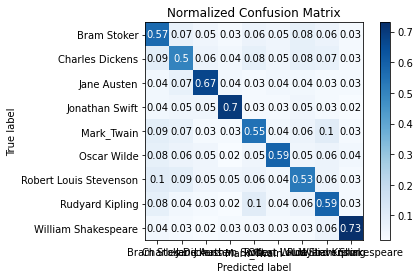

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(author_test, author_pred4, normalize=True)

In [ ]:
# Model 2 sensitivity testing

kf = KFold(n_splits = 3)

accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
cnt = 0

# Convert sparse matrix to array
words_train_np = words_train.toarray()

for train_inds, _ in kf.split(words_train):
    cnt += 1
    print('Run:', cnt)

    # Create data subsets
    train_x = np.array([words_train_np[i] for i in train_inds])
    train_y = [author_train[i] for i in train_inds]

    # Convert train_x back to sparse matrix
    train_x = sparse.csr_matrix(train_x)

    # Fit model
    model2 = SVC(C = 1, kernel = 'linear')
    model2.fit(train_x, train_y)


    # Predict values for test set
    author_pred4 = model2.predict(words_test)

    # Evaluate
    accuracy = accuracy_score(author_test, author_pred4)
    precision, recall, f1, support = score(author_test, author_pred4)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))

    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print("Accuracy:", accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1
Run: 2
Run: 3
Accuracy: [0.5832777777777778, 0.5873888888888888, 0.5856111111111111]
Ave. Precision: [0.5868646800639152, 0.5907448578205553, 0.5903875327211403]
Ave. Recall: [0.5832777777777779, 0.587388888888889, 0.5856111111111111]
Ave. F1 Score: [0.5845207509666979, 0.5885023582025268, 0.58720786410805]


In [ ]:
# Explore the first 100 test examples
for i in range(100):
    print('Excerpt', i, '- Actual label =', author_test[i],
         'Model 2 predicted label =', author_pred4[i])
    print(text_test[i], '\n')

Excerpt 0 - Actual label = Jonathan Swift Model 2 predicted label = Jonathan Swift
i think i will send him word that i never saw my lord treasurer in my life i am sure i industriously avoided the name of any great person when i saw him for fear of his reporting it in ireland 

Excerpt 1 - Actual label = Charles Dickens Model 2 predicted label = Charles Dickens
it seemed that caddys unfortunate papa had got over his bankruptcy gone through the gazette was the expression caddy used as if it were a tunnel with the general clemency and commiseration of his creditors and had got rid of his affairs in some blessed manner without succeeding in understanding them and had given up everything he possessed which was not worth much i should think to judge from the state of the furniture and had satisfied every one concerned that he could do no more poor man 

Excerpt 2 - Actual label = Mark_Twain Model 2 predicted label = Charles Dickens
i am below the figures rather than above them 

Excerpt 3 - 